In [1]:
# Cell 1: Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    roc_auc_score, confusion_matrix, classification_report,
    roc_curve, precision_recall_curve
)
import os
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Cell 2: Load preprocessed data from Step 1
X_train_scaled = np.load('../src/data/processed/X_train_scaled.npy')
X_test_scaled = np.load('../src/data/processed/X_test_scaled.npy')
y_train = np.load('../src/data/processed/y_train.npy')
y_test = np.load('../src/data/processed/y_test.npy')

print(f"Training data shape: {X_train_scaled.shape}")
print(f"Test data shape: {X_test_scaled.shape}")
print(f"Training labels distribution: {np.bincount(y_train)}")
print(f"Test labels distribution: {np.bincount(y_test)}")

Training data shape: (455, 30)
Test data shape: (114, 30)
Training labels distribution: [170 285]
Test labels distribution: [42 72]


In [5]:
# Cell 3: Initialize baseline models with optimal parameters based on literature[133][136]
models = {
    'Logistic Regression': LogisticRegression(
        random_state=42, 
        max_iter=1000,
        solver='lbfgs'
    ),
    'Decision Tree': DecisionTreeClassifier(
        random_state=42,
        max_depth=10,
        min_samples_split=5
    ),
    'Random Forest': RandomForestClassifier(
        random_state=42,
        n_estimators=100,
        max_depth=10,
        min_samples_split=5
    )
}

print("Baseline Models Initialized:")
for name, model in models.items():
    print(f"- {name}: {model.__class__.__name__}")

Baseline Models Initialized:
- Logistic Regression: LogisticRegression
- Decision Tree: DecisionTreeClassifier
- Random Forest: RandomForestClassifier


In [6]:
# Cell 4: Define comprehensive evaluation function
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name):
    """
    Comprehensive model evaluation for imbalanced classification.
    
    Returns:
        dict: Complete evaluation metrics
    """
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    # Calculate metrics appropriate for imbalanced data[132][61]
    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred, average='weighted'),
        'Recall': recall_score(y_test, y_pred, average='weighted'),
        'F1_Score': f1_score(y_test, y_pred, average='weighted'),
        'ROC_AUC': roc_auc_score(y_test, y_pred_proba),
        
        # Class-specific metrics (critical for imbalanced data)
        'Precision_Class_0': precision_score(y_test, y_pred, pos_label=0),  # Malignant
        'Recall_Class_0': recall_score(y_test, y_pred, pos_label=0),        # Malignant
        'F1_Class_0': f1_score(y_test, y_pred, pos_label=0),                # Malignant
        
        'Precision_Class_1': precision_score(y_test, y_pred, pos_label=1),  # Benign
        'Recall_Class_1': recall_score(y_test, y_pred, pos_label=1),        # Benign
        'F1_Class_1': f1_score(y_test, y_pred, pos_label=1),                # Benign
    }
    
    # Print detailed results
    print(f"\n{'='*50}")
    print(f"Model: {model_name}")
    print(f"{'='*50}")
    print(f"Overall Performance:")
    print(f"  Accuracy: {metrics['Accuracy']:.4f}")
    print(f"  Precision (weighted): {metrics['Precision']:.4f}")
    print(f"  Recall (weighted): {metrics['Recall']:.4f}")
    print(f"  F1-Score (weighted): {metrics['F1_Score']:.4f}")
    print(f"  ROC-AUC: {metrics['ROC_AUC']:.4f}")
    
    print(f"\nClass-Specific Performance:")
    print(f"  Malignant (Class 0) - Precision: {metrics['Precision_Class_0']:.4f}, "
          f"Recall: {metrics['Recall_Class_0']:.4f}, F1: {metrics['F1_Class_0']:.4f}")
    print(f"  Benign (Class 1) - Precision: {metrics['Precision_Class_1']:.4f}, "
          f"Recall: {metrics['Recall_Class_1']:.4f}, F1: {metrics['F1_Class_1']:.4f}")
    
    # Detailed classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y_test, y_pred, target_names=['Malignant', 'Benign']))
    
    return metrics, y_pred, y_pred_proba

In [7]:
# Cell 5: Train and evaluate all baseline models
results = []
predictions = {}
probabilities = {}

for name, model in models.items():
    print(f"Training and evaluating {name}...")
    metrics, y_pred, y_pred_proba = evaluate_model(
        model, X_train_scaled, y_train, X_test_scaled, y_test, name
    )
    
    results.append(metrics)
    predictions[name] = y_pred
    probabilities[name] = y_pred_proba

# Create results DataFrame
results_df = pd.DataFrame(results)
print("\n" + "="*80)
print("BASELINE MODELS COMPARISON")
print("="*80)
print(results_df[['Model', 'Accuracy', 'Precision', 'Recall', 'F1_Score', 'ROC_AUC']].round(4))

Training and evaluating Logistic Regression...

Model: Logistic Regression
Overall Performance:
  Accuracy: 0.9825
  Precision (weighted): 0.9825
  Recall (weighted): 0.9825
  F1-Score (weighted): 0.9825
  ROC-AUC: 0.9954

Class-Specific Performance:
  Malignant (Class 0) - Precision: 0.9762, Recall: 0.9762, F1: 0.9762
  Benign (Class 1) - Precision: 0.9861, Recall: 0.9861, F1: 0.9861

Detailed Classification Report:
              precision    recall  f1-score   support

   Malignant       0.98      0.98      0.98        42
      Benign       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Training and evaluating Decision Tree...

Model: Decision Tree
Overall Performance:
  Accuracy: 0.9035
  Precision (weighted): 0.9090
  Recall (weighted): 0.9035
  F1-Score (weighted): 0.9045
  ROC-AUC: 0.9216

Class-Specific Performance:
  Malignant (

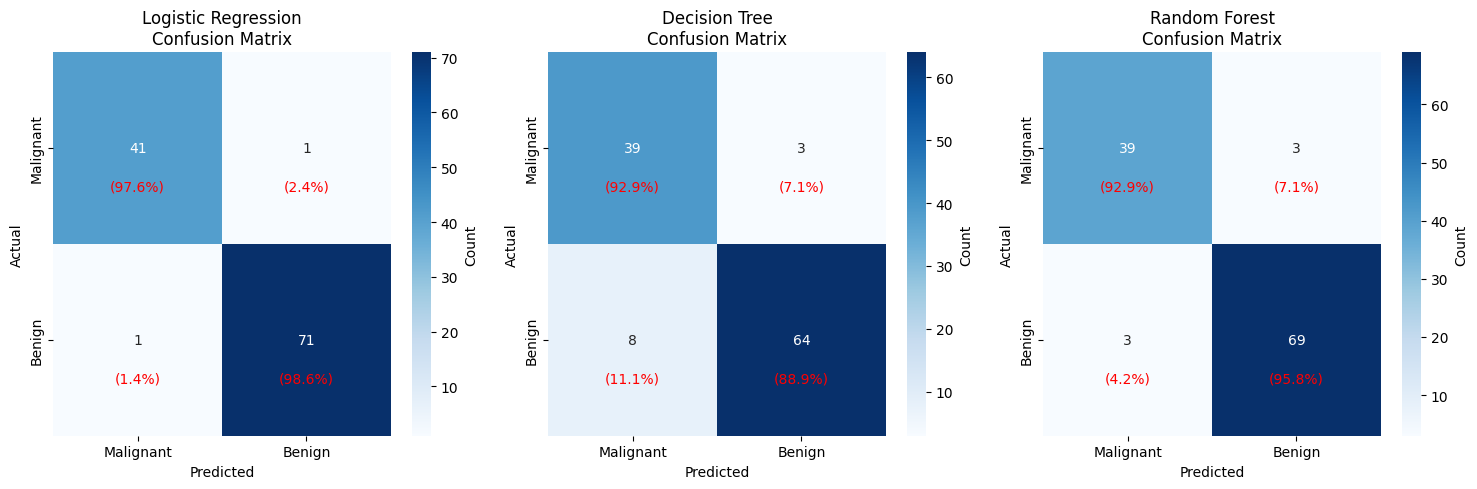

In [8]:
# Cell 6: Generate and visualize confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
class_names = ['Malignant', 'Benign']

for i, (name, y_pred) in enumerate(predictions.items()):
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate percentages
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Plot confusion matrix
    sns.heatmap(cm, annot=True, fmt='d', ax=axes[i], 
                xticklabels=class_names, yticklabels=class_names,
                cmap='Blues', cbar_kws={'label': 'Count'})
    
    axes[i].set_title(f'{name}\nConfusion Matrix')
    axes[i].set_xlabel('Predicted')
    axes[i].set_ylabel('Actual')
    
    # Add percentage annotations
    for j in range(2):
        for k in range(2):
            axes[i].text(k+0.5, j+0.7, f'({cm_normalized[j,k]:.1f}%)', 
                        ha='center', va='center', fontsize=10, color='red')

plt.tight_layout()
os.makedirs('../reports/figures', exist_ok=True)
plt.savefig('../reports/figures/baseline_confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

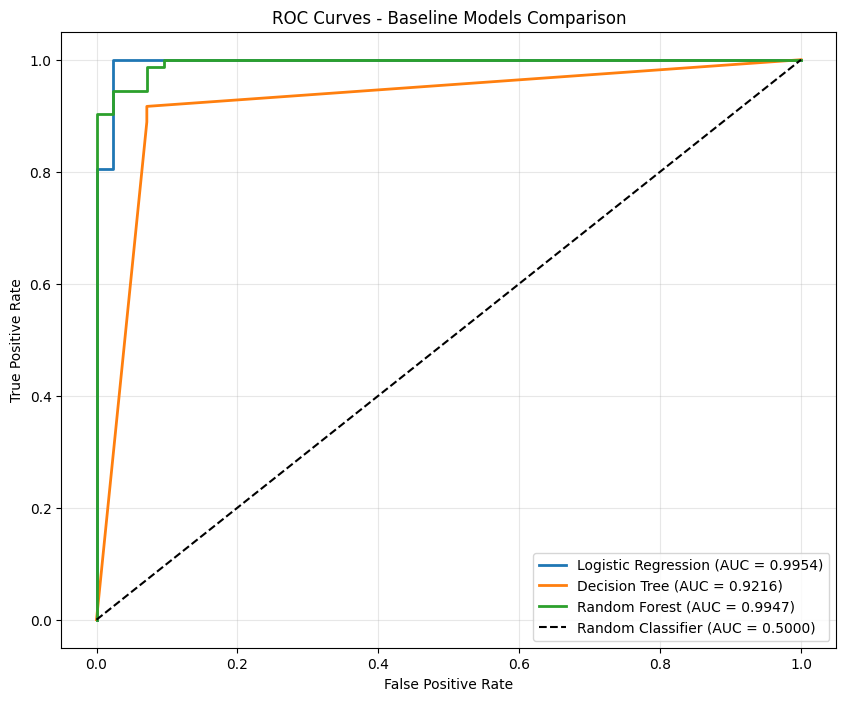

In [9]:
plt.figure(figsize=(10, 8))

for name, y_pred_proba in probabilities.items():
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    auc_score = roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5000)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Baseline Models Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('../reports/figures/baseline_roc_curves.png', dpi=300, bbox_inches='tight')
plt.show()

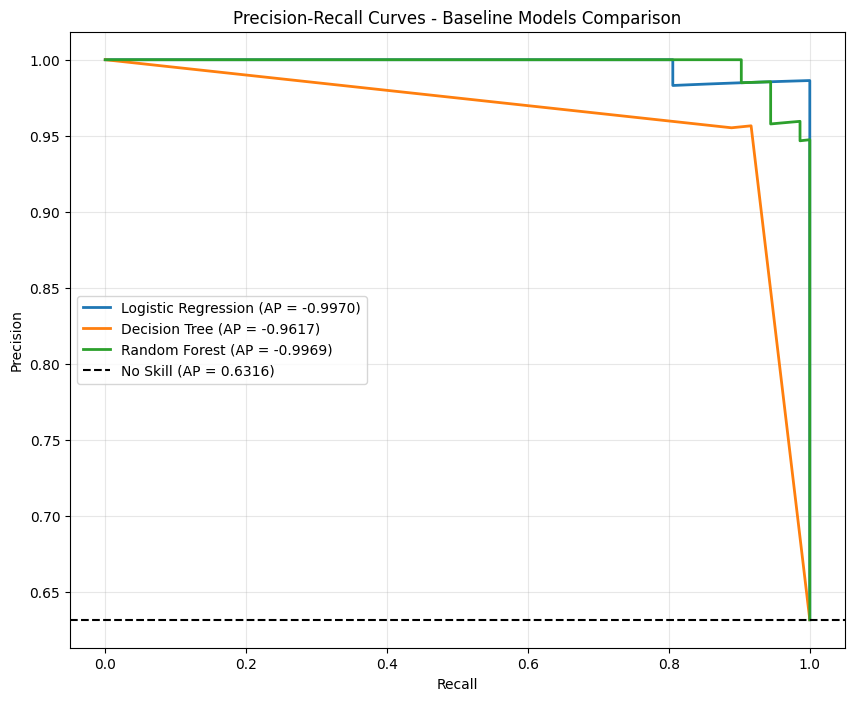

In [10]:
# Cell 8: Precision-Recall curves (critical for imbalanced data[61][67])
plt.figure(figsize=(10, 8))

for name, y_pred_proba in probabilities.items():
    precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
    avg_precision = np.trapz(precision, recall)
    plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.4f})', linewidth=2)

# Baseline (no-skill classifier)
no_skill = len(y_test[y_test==1]) / len(y_test)
plt.axhline(y=no_skill, color='k', linestyle='--', 
           label=f'No Skill (AP = {no_skill:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves - Baseline Models Comparison')
plt.legend()
plt.grid(alpha=0.3)
plt.savefig('../reports/figures/baseline_pr_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [11]:
# Cell 9: Analyze the accuracy paradox and class imbalance impact[137][141]
print("="*80)
print("ACCURACY PARADOX ANALYSIS")
print("="*80)

# Calculate majority class baseline (ZeroR classifier[141])
majority_class = np.bincount(y_test).argmax()
majority_baseline = np.max(np.bincount(y_test)) / len(y_test)

print(f"Dataset Characteristics:")
print(f"  Total test samples: {len(y_test)}")
print(f"  Malignant (0): {np.sum(y_test == 0)} ({np.sum(y_test == 0)/len(y_test)*100:.1f}%)")
print(f"  Benign (1): {np.sum(y_test == 1)} ({np.sum(y_test == 1)/len(y_test)*100:.1f}%)")
print(f"  Majority class: {majority_class} ({'Benign' if majority_class == 1 else 'Malignant'})")
print(f"  ZeroR Baseline Accuracy: {majority_baseline:.4f}")

print(f"\nModel Performance vs Baseline:")
for _, row in results_df.iterrows():
    model_name = row['Model']
    accuracy = row['Accuracy']
    improvement = accuracy - majority_baseline
    print(f"  {model_name}: {accuracy:.4f} (Δ = +{improvement:.4f})")

# Highlight the importance of minority class metrics
print(f"\nMINORITY CLASS (MALIGNANT) PERFORMANCE:")
print("="*50)
for _, row in results_df.iterrows():
    print(f"{row['Model']}:")
    print(f"  Precision: {row['Precision_Class_0']:.4f}")
    print(f"  Recall: {row['Recall_Class_0']:.4f}")
    print(f"  F1-Score: {row['F1_Class_0']:.4f}")

ACCURACY PARADOX ANALYSIS
Dataset Characteristics:
  Total test samples: 114
  Malignant (0): 42 (36.8%)
  Benign (1): 72 (63.2%)
  Majority class: 1 (Benign)
  ZeroR Baseline Accuracy: 0.6316

Model Performance vs Baseline:
  Logistic Regression: 0.9825 (Δ = +0.3509)
  Decision Tree: 0.9035 (Δ = +0.2719)
  Random Forest: 0.9474 (Δ = +0.3158)

MINORITY CLASS (MALIGNANT) PERFORMANCE:
Logistic Regression:
  Precision: 0.9762
  Recall: 0.9762
  F1-Score: 0.9762
Decision Tree:
  Precision: 0.8298
  Recall: 0.9286
  F1-Score: 0.8764
Random Forest:
  Precision: 0.9286
  Recall: 0.9286
  F1-Score: 0.9286


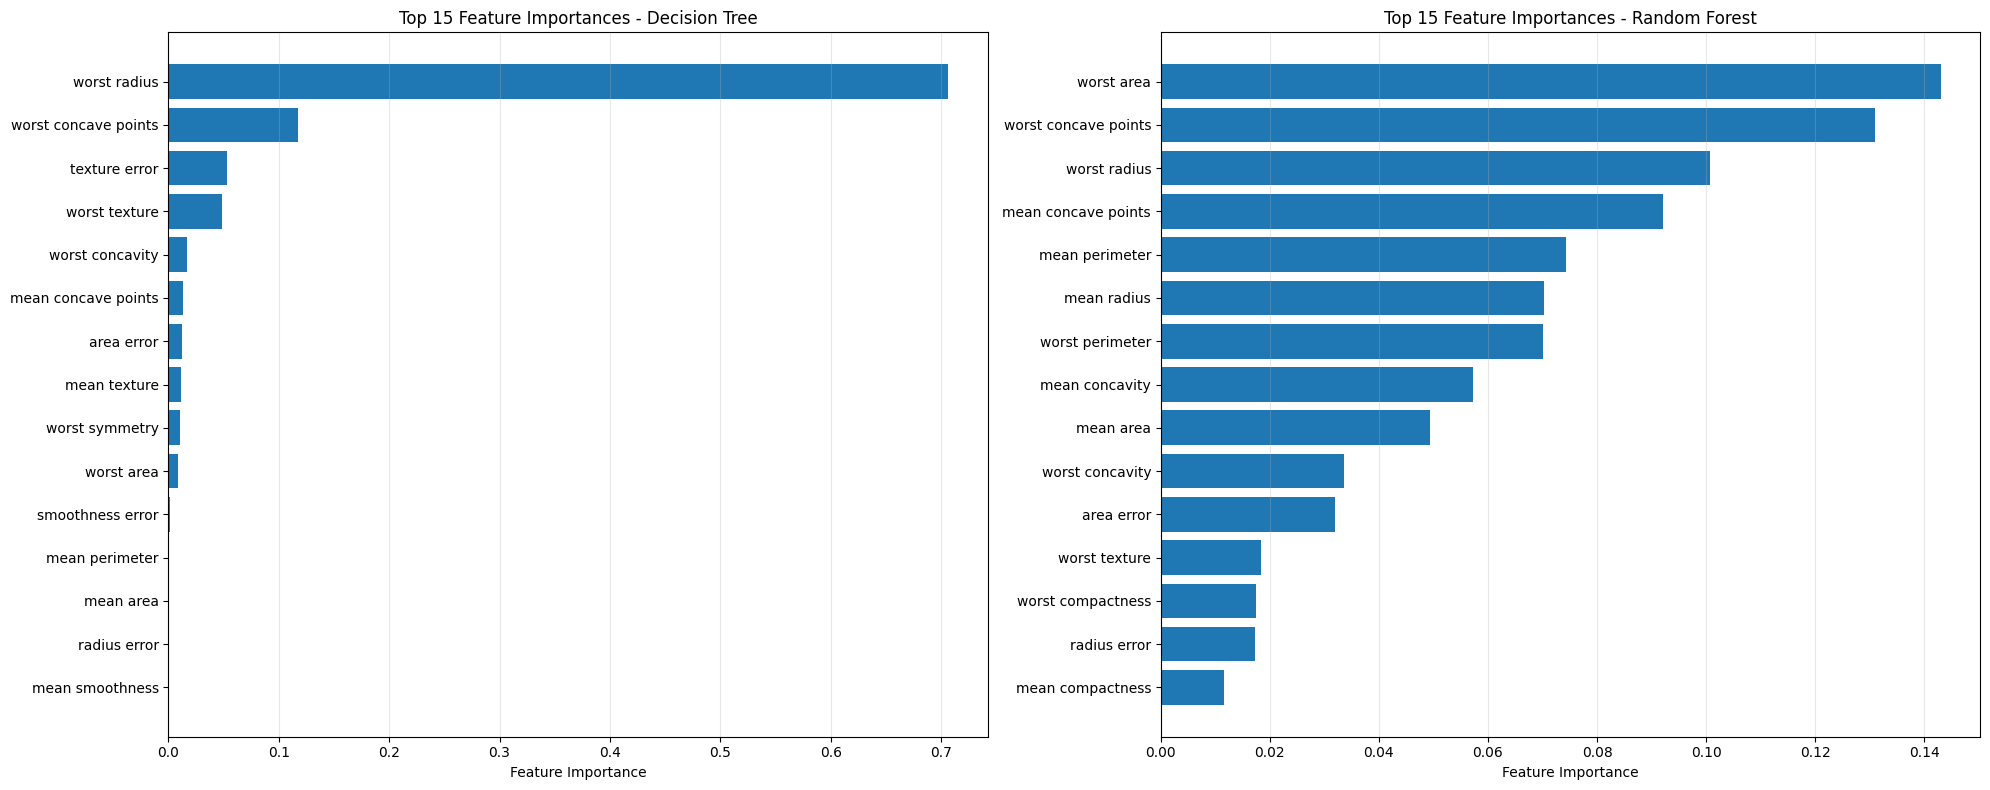

In [12]:
# Cell 10: Feature importance analysis
from sklearn.datasets import load_breast_cancer

# Load original feature names
data = load_breast_cancer()
feature_names = data.feature_names

# Get feature importance for tree-based models
tree_models = ['Decision Tree', 'Random Forest']

fig, axes = plt.subplots(1, 2, figsize=(20, 8))

for i, name in enumerate(tree_models):
    model = models[name]
    # Re-fit to ensure we have the trained model
    model.fit(X_train_scaled, y_train)
    
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:15]  # Top 15 features
    
    axes[i].barh(range(15), importances[indices][::-1])
    axes[i].set_yticks(range(15))
    axes[i].set_yticklabels([feature_names[j] for j in indices[::-1]])
    axes[i].set_xlabel('Feature Importance')
    axes[i].set_title(f'Top 15 Feature Importances - {name}')
    axes[i].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('../reports/figures/baseline_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [13]:
# Cell 11: Cross-validation for robust performance estimation
from sklearn.model_selection import cross_val_score, StratifiedKFold

print("="*80)
print("CROSS-VALIDATION ANALYSIS")
print("="*80)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = {}

for name, model in models.items():
    print(f"\nCross-validating {name}...")
    
    # Multiple metrics
    accuracy_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='accuracy')
    f1_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='f1_weighted')
    precision_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='precision_weighted')
    recall_scores = cross_val_score(model, X_train_scaled, y_train, cv=cv, scoring='recall_weighted')
    
    cv_results[name] = {
        'Accuracy': accuracy_scores,
        'F1_Score': f1_scores,
        'Precision': precision_scores,
        'Recall': recall_scores
    }
    
    print(f"  Accuracy: {accuracy_scores.mean():.4f} (±{accuracy_scores.std()*2:.4f})")
    print(f"  F1-Score: {f1_scores.mean():.4f} (±{f1_scores.std()*2:.4f})")
    print(f"  Precision: {precision_scores.mean():.4f} (±{precision_scores.std()*2:.4f})")
    print(f"  Recall: {recall_scores.mean():.4f} (±{recall_scores.std()*2:.4f})")

CROSS-VALIDATION ANALYSIS

Cross-validating Logistic Regression...
  Accuracy: 0.9780 (±0.0197)
  F1-Score: 0.9780 (±0.0198)
  Precision: 0.9785 (±0.0190)
  Recall: 0.9780 (±0.0197)

Cross-validating Decision Tree...
  Accuracy: 0.9187 (±0.0264)
  F1-Score: 0.9192 (±0.0262)
  Precision: 0.9226 (±0.0249)
  Recall: 0.9187 (±0.0264)

Cross-validating Random Forest...
  Accuracy: 0.9582 (±0.0323)
  F1-Score: 0.9582 (±0.0321)
  Precision: 0.9590 (±0.0318)
  Recall: 0.9582 (±0.0323)


In [14]:
# Cell 12: Save results and trained models
import joblib

# Save results to CSV
results_df.to_csv('../results/baseline_results.csv', index=False)
print("Results saved to ../results/baseline_results.csv")

# Save trained models
os.makedirs('../models/baseline', exist_ok=True)
for name, model in models.items():
    model_filename = name.lower().replace(' ', '_') + '.joblib'
    model_path = f'../models/baseline/{model_filename}'
    joblib.dump(model, model_path)
    print(f"Saved {name} model to {model_path}")

print("\nStep 2 completed successfully!")
print("Generated files:")
print("- ../reports/figures/baseline_confusion_matrices.png")
print("- ../reports/figures/baseline_roc_curves.png") 
print("- ../reports/figures/baseline_pr_curves.png")
print("- ../reports/figures/baseline_feature_importance.png")
print("- ../results/baseline_results.csv")
print("- ../models/baseline/logistic_regression.joblib")
print("- ../models/baseline/decision_tree.joblib")
print("- ../models/baseline/random_forest.joblib")

Results saved to ../results/baseline_results.csv
Saved Logistic Regression model to ../models/baseline/logistic_regression.joblib
Saved Decision Tree model to ../models/baseline/decision_tree.joblib
Saved Random Forest model to ../models/baseline/random_forest.joblib

Step 2 completed successfully!
Generated files:
- ../reports/figures/baseline_confusion_matrices.png
- ../reports/figures/baseline_roc_curves.png
- ../reports/figures/baseline_pr_curves.png
- ../reports/figures/baseline_feature_importance.png
- ../results/baseline_results.csv
- ../models/baseline/logistic_regression.joblib
- ../models/baseline/decision_tree.joblib
- ../models/baseline/random_forest.joblib
